# **Model Evaluation:**

In [ ]:
!pip install torchxrayvision

**IMPORT LIBRARIES:**

In [ ]:
# System and OS utilities
import os
import sys
import json
import random

# Data manipulation
import pandas as pd
import numpy as np
from tqdm import tqdm

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Image processing
from PIL import Image, ImageEnhance, ImageOps

# PyTorch and related libraries
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchxrayvision as xrv

# Scikit-learn utilities
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_curve,
    auc,
    precision_recall_curve,
    average_precision_score
)

**PATH SETUP:**

In [ ]:
# For running in Colab
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    BASE_DIR = "/content/drive/MyDrive/CV_Project/BTXRD"
else:
    try:

        SCRIPT_DIR = os.path.dirname(os.path.abspath(__file__))
    except NameError:

        SCRIPT_DIR = os.getcwd()


    BASE_DIR = os.path.abspath(os.path.join(SCRIPT_DIR, ".."))

    if not os.path.exists(BASE_DIR):
        raise FileNotFoundError(f"BASE_DIR not found: {BASE_DIR}")

# My directories
METADATA_DIR = os.path.join(BASE_DIR, "metadata")
ANNOTATIONS_DIR = os.path.join(BASE_DIR, "Annotations")
MODELS_DIR = os.path.join(BASE_DIR, "models")
HISTORY_DIR = os.path.join(BASE_DIR, "history")

#
if not IN_COLAB:
    os.makedirs(MODELS_DIR, exist_ok=True)
    os.makedirs(HISTORY_DIR, exist_ok=True)

# Metadata full paths:
main_path = os.path.join(METADATA_DIR, "main_dataframe.xlsx")
annot_path = os.path.join(METADATA_DIR, "annotated_dataframe.xlsx")

# Check file existence:
assert os.path.exists(main_path), f"Missing file: {main_path}"
assert os.path.exists(annot_path), f"Missing file: {annot_path}"

# Load data
main_df = pd.read_excel(main_path)
annotated_df = pd.read_excel(annot_path)

# Image path: I running in Colabb:
if IN_COLAB:
    for df in [main_df, annotated_df]:
        df["image_path"] = df["image_path"].str.replace(
            "/content/drive/MyDrive/CV_Project/BTXRD", BASE_DIR
        )

print("Data loaded successfully.")
print(f"BASE_DIR is set to: {BASE_DIR}")
print(f"Metadata directory: {METADATA_DIR}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Data loaded successfully.
BASE_DIR is set to: /content/drive/MyDrive/CV_Project/BTXRD
Metadata directory: /content/drive/MyDrive/CV_Project/BTXRD/metadata


**EVALUATION WRAPPER FUNCTIONS:**

In [ ]:
def evaluate_model(model, dataloader, device, class_names, dataset_name="Dataset"):
    model.eval()
    y_true, y_pred = [], []

    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc=f"Evaluating {dataset_name}"):
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    print(f"\nClassification Report for {dataset_name}:\n")
    labels_range = list(range(len(class_names)))  # [0, 1, 2]
    print(classification_report(
        y_true, y_pred,
        labels=labels_range,
        target_names=class_names,
        zero_division=0
    ))

    cm = confusion_matrix(y_true, y_pred, labels=labels_range)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Confusion Matrix - {dataset_name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.show()


def plot_training_curves(history_df, title_prefix=""):
      epochs = range(1, len(history_df) + 1)
      fig, axes = plt.subplots(2, 1, figsize=(10, 10))

      # Accuracy
      axes[0].plot(epochs, history_df['train_acc'], label='Train Accuracy', color='tab:blue')
      axes[0].plot(epochs, history_df['val_acc'], label='Validation Accuracy', color='tab:orange')
      axes[0].set_title(f'{title_prefix}Accuracy vs Epochs')
      axes[0].set_xlabel('Epoch')
      axes[0].set_ylabel('Accuracy')
      axes[0].legend()
      axes[0].grid(True)

      # Loss
      axes[1].plot(epochs, history_df['train_loss'], label='Train Loss', color='tab:red')
      axes[1].plot(epochs, history_df['val_loss'], label='Validation Loss', color='tab:green')
      axes[1].set_title(f'{title_prefix}Loss vs Epochs')
      axes[1].set_xlabel('Epoch')
      axes[1].set_ylabel('Loss')
      axes[1].legend()
      axes[1].grid(True)

      plt.tight_layout()
      plt.show()

def evaluate_and_plot_cm(model, dataloader, class_names, dataset_name):
    model.eval()
    y_true, y_pred = [], []
    y_scores = []  

    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc=f"Evaluating {dataset_name}"):
            images = images.to(device)
            outputs = model(images) 
            probs = torch.softmax(outputs, dim=1) 
            _, preds = torch.max(outputs, 1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
            y_scores.extend(probs.cpu().numpy()) 

    print(f"Classification Report - {dataset_name}")
    print(classification_report(y_true, y_pred, target_names=class_names, zero_division=0))

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Confusion Matrix - {dataset_name}')
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

    return np.array(y_true), np.array(y_scores) 


def plot_roc_pr_curves(model, dataloader, dataset_name):
    model.eval()
    y_true = []
    y_scores = []

    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc=f"Generating Scores for {dataset_name}"):
            images = images.to(device)
            outputs = model(images)
            y_scores.append(outputs.cpu())
            y_true.extend(labels.cpu())

    y_scores = torch.cat(y_scores).numpy()
    y_true = np.array(y_true)
    y_true_bin = np.eye(len(class_names))[y_true]

    plt.figure(figsize=(12, 5))

    # --- ROC Curves ---
    plt.subplot(1, 2, 1)
    for i in range(len(class_names)):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_scores[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"{class_names[i]} (AUC = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title(f"ROC Curves - {dataset_name}")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()

    # --- Precision-Recall Curves ---
    plt.subplot(1, 2, 2)
    for i in range(len(class_names)):
        precision, recall, _ = precision_recall_curve(y_true_bin[:, i], y_scores[:, i])
        ap = average_precision_score(y_true_bin[:, i], y_scores[:, i])
        plt.plot(recall, precision, label=f"{class_names[i]} (AP = {ap:.2f})")
    plt.title(f"Precision-Recall Curves - {dataset_name}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.legend()

    plt.tight_layout()
    plt.show()


def binary_normal_vs_tumor_analysis(y_true, y_scores, dataset_name="Dataset"):
    import numpy as np
    from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score
    import matplotlib.pyplot as plt
    import seaborn as sns

    y_true = np.array(y_true)
    y_scores = np.array(y_scores)

    # Binary true labels: Normal=0, Tumor=1
    y_true_bin = (y_true != 0).astype(int)

    # Calculate combined tumor probability
    tumor_prob = y_scores[:, 1] + y_scores[:, 2]
    normal_prob = y_scores[:, 0]

    # Binary predictions based on max probability between normal and tumor
    y_pred_bin = (tumor_prob > normal_prob).astype(int)

    # Classification report
    print(f"Binary Classification Report (Normal vs Tumor) - {dataset_name}")
    print(classification_report(y_true_bin, y_pred_bin, target_names=['Normal', 'Tumor'], zero_division=0))

    # Confusion matrix plot
    cm = confusion_matrix(y_true_bin, y_pred_bin)
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Normal', 'Tumor'], yticklabels=['Normal', 'Tumor'])
    plt.title(f'Confusion Matrix (Normal vs Tumor) - {dataset_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()

    # ROC curve & AUC
    fpr, tpr, _ = roc_curve(y_true_bin, tumor_prob)
    roc_auc = auc(fpr, tpr)

    # Precision-Recall curve & Average Precision
    precision, recall, _ = precision_recall_curve(y_true_bin, tumor_prob)
    ap = average_precision_score(y_true_bin, tumor_prob)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, label=f'Normal vs Tumor (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title(f'ROC Curve - {dataset_name}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(recall, precision, label=f'Normal vs Tumor (AP = {ap:.2f})')
    plt.title(f'Precision-Recall Curve - {dataset_name}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend()

    plt.tight_layout()
    plt.show()

**LOAD DATASET:**

In [ ]:
main_df = pd.read_excel(os.path.join(METADATA_DIR,"main_dataframe.xlsx"))
annotated_df = pd.read_excel(os.path.join(METADATA_DIR,"annotated_dataframe.xlsx"))

**PREPARE DATASET FOR INFERENCE:**

In [ ]:
model_df = main_df[(main_df['lower limb']==1) | (main_df['pelvis']==1)]

print("Fcoused on lower limb and pelvis body parts only.\n")
print(f"Shape of the focused dataframe:{model_df.shape}\n")

print("Class distribution:")
print("-------------------")

print(f"{model_df['label'].value_counts()}\n")

Fcoused on lower limb and pelvis body parts only.

Shape of the focused dataframe:(2622, 42)

Class distribution:
-------------------
label
Normal       1207
Benign       1153
Malignant     262
Name: count, dtype: int64



In [ ]:
train_df,temp_df = train_test_split(model_df,
                                    stratify=model_df['label'],
                                    test_size = 0.35,
                                    random_state=369)

val_df,test_df = train_test_split(temp_df,
                                  stratify=temp_df['label'],
                                  test_size=20/35,
                                  random_state=369)

# Train, Validation & Test Split size:
print(f"Train Dataset Size : {train_df.shape}")
print(f"Validation Dataset Size : {val_df.shape}")
print(f"Test Dataset Size : {test_df.shape}")

Train Dataset Size : (1704, 42)
Validation Dataset Size : (393, 42)
Test Dataset Size : (525, 42)


**AUGMENTATION:**

In [ ]:
def strong_augment_pil(img: Image.Image):
    """Augmentation : Rotation, flip, zoom (crop & resize), brightness/contrast."""

    # Random rotate
    angle = random.choice([0, 90, 180, 270]) if random.random() < 0.4 else random.uniform(-20, 20)
    img = img.rotate(angle)

    # Horizontal flip
    if random.random() < 0.5:
        img = img.transpose(Image.FLIP_LEFT_RIGHT)

    # Random zoom via center crop
    if random.random() < 0.6:
        w, h = img.size
        zoom = random.uniform(0.85, 1.0)
        new_w, new_h = int(w*zoom), int(h*zoom)
        left = (w - new_w) // 2
        top  = (h - new_h) // 2
        img = img.crop((left, top, left+new_w, top+new_h))
        img = img.resize((w, h), Image.BICUBIC)

    # Brightness & contrast
    if random.random() < 0.8:
        img = ImageEnhance.Brightness(img).enhance(random.uniform(0.8, 1.2))
    if random.random() < 0.8:
        img = ImageEnhance.Contrast(img).enhance(random.uniform(0.8, 1.3))

    return img


def augment_malignant_to_target(train_df, target_per_class=None, copies_per_image=None, img_size=(224,224)):

    malignant_df = train_df[train_df['label'] == 'Malignant'].copy()
    benign_df    = train_df[train_df['label'] == 'Benign'].copy()
    normal_df    = train_df[train_df['label'] == 'Normal'].copy()

    counts = {
        'Normal': len(normal_df),
        'Benign': len(benign_df),
        'Malignant': len(malignant_df)
    }
    print("Pre-augmentation:", counts)

    if target_per_class is None and copies_per_image is None:
        target_per_class = max(counts['Normal'], counts['Benign'])

    if target_per_class is not None:
        need = max(0, target_per_class - counts['Malignant'])
    else:
        need = len(malignant_df) * copies_per_image

    if need == 0:
        print("No malignant augmentation needed.")
        return train_df

    aug_rows = []
    malignant_paths = malignant_df['image_path'].tolist()
    n = len(malignant_paths)

    created = 0
    idx = 0
    while created < need:
        src_row = malignant_df.iloc[idx % n]
        src_path = src_row['image_path']
        try:
            with Image.open(src_path) as img:
                if img.mode != 'RGB':
                    img = img.convert('RGB')
                img = img.resize(img_size, Image.BICUBIC)
                img_aug = strong_augment_pil(img)

                base = os.path.splitext(os.path.basename(src_path))[0]
                out_name = f"{base}_AUG_{created:05d}.jpg"


                os.makedirs(AUG_DIR, exist_ok=True)
                out_path = os.path.join(AUG_DIR, out_name)
                img_aug.save(out_path, quality=95)


                new_row = src_row.copy()
                new_row['image_path'] = out_path

                aug_rows.append(new_row)
                created += 1
        except Exception as e:
            print(f"Aug error: {src_path} -> {e}")
        idx += 1

    aug_df = pd.DataFrame(aug_rows)
    train_df_aug = pd.concat([train_df, aug_df], ignore_index=True)

    print("Post-augmentation counts:\n", train_df_aug['label'].value_counts())
    return train_df_aug

In [ ]:
# Create Folder to store augmented images.
AUG_DIR = os.path.join(BASE_DIR,"augmented_malignant")
os.makedirs(AUG_DIR,exist_ok=True)

# Applying augmentation to oversample malignant class images to match with normal class.
max_train_class = train_df['label'].value_counts().max()
train_df_aug = augment_malignant_to_target(train_df, target_per_class=max_train_class, img_size=(224,224))

Pre-augmentation: {'Normal': 785, 'Benign': 749, 'Malignant': 170}
Post-augmentation counts:
 label
Normal       785
Malignant    785
Benign       749
Name: count, dtype: int64


**LOAD MODELS:**

D121_Chexpert Model:

In [ ]:
class DenseNet121CheXpertFineTune(nn.Module):
    def __init__(self, num_classes=3):
        super().__init__()
        self.backbone = xrv.models.DenseNet(weights="densenet121-res224-chex")


        for param in self.backbone.parameters():
            param.requires_grad = False

        self.features = self.backbone.features

        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.classifier = nn.Sequential(
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.5),

            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = 3 
d121_full = DenseNet121CheXpertFineTune(num_classes=num_classes).to(device)


d121_full.load_state_dict(torch.load(os.path.join('/content/drive/MyDrive/CV_Project',"best_model_ft_40layers.pth"), map_location=device))
d121_full.eval()

print("D121_Chexpert_full Model loaded and ready for inference.")

D121_Chexpert_full Model loaded and ready for inference.


D121_Chexpert_BB_Model:

In [ ]:
class DenseNet121_BB(nn.Module):
    def __init__(self, num_classes=3):
        super(DenseNet121_BB, self).__init__()

        self.backbone = xrv.models.DenseNet(weights="densenet121-res224-chex")

        for param in self.backbone.parameters():
            param.requires_grad = False

        self.features = self.backbone.features

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Sequential(
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.5),

            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = 3

# Phase-1 Model:
D121_bb_ph1 = DenseNet121_BB(num_classes=num_classes).to(device)
D121_bb_ph1.load_state_dict(torch.load(os.path.join(MODELS_DIR,"dense_bb_phase1.pth"), map_location=device))
D121_bb_ph1.eval()

# Phase-2 Model:
D121_bb_ph2 = DenseNet121_BB(num_classes=num_classes).to(device)
D121_bb_ph2.load_state_dict(torch.load(os.path.join(MODELS_DIR,"dense_bb_phase1.pth"), map_location=device))
D121_bb_ph2.eval()

print("D121_BB model loaded successfully.")


D121_BB model loaded successfully.


---
## **MODEL INFERENCE:**

## Evaluation - DenseNet121_CHEXPERT_FULL (No Bounding Boxes)


Evaluating Train Set: 100%|██████████| 73/73 [14:28<00:00, 11.90s/it]



Classification Report for Train Set:

              precision    recall  f1-score   support

      Normal       0.68      0.65      0.66       749
      Benign       0.89      0.78      0.83       785
   Malignant       0.71      0.82      0.76       785

    accuracy                           0.75      2319
   macro avg       0.76      0.75      0.75      2319
weighted avg       0.76      0.75      0.75      2319



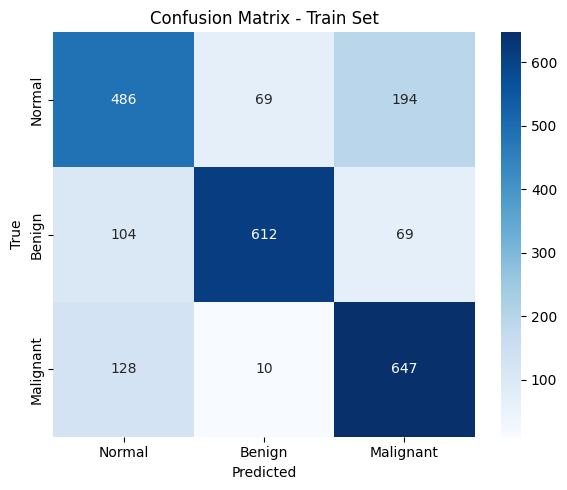

Evaluating Validation Set: 100%|██████████| 13/13 [02:29<00:00, 11.51s/it]



Classification Report for Validation Set:

              precision    recall  f1-score   support

      Normal       0.73      0.64      0.68       173
      Benign       0.42      0.46      0.44        39
   Malignant       0.73      0.80      0.76       181

    accuracy                           0.69       393
   macro avg       0.63      0.63      0.63       393
weighted avg       0.70      0.69      0.69       393



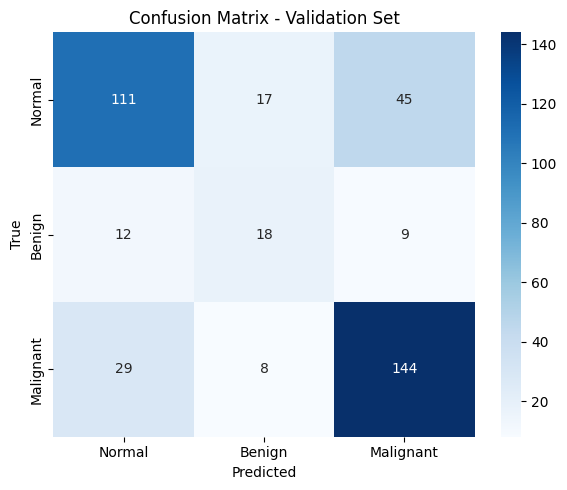

Evaluating Test Set: 100%|██████████| 17/17 [03:18<00:00, 11.68s/it]



Classification Report for Test Set:

              precision    recall  f1-score   support

      Normal       0.70      0.61      0.65       231
      Benign       0.46      0.55      0.50        53
   Malignant       0.71      0.78      0.74       241

    accuracy                           0.68       525
   macro avg       0.62      0.64      0.63       525
weighted avg       0.68      0.68      0.68       525



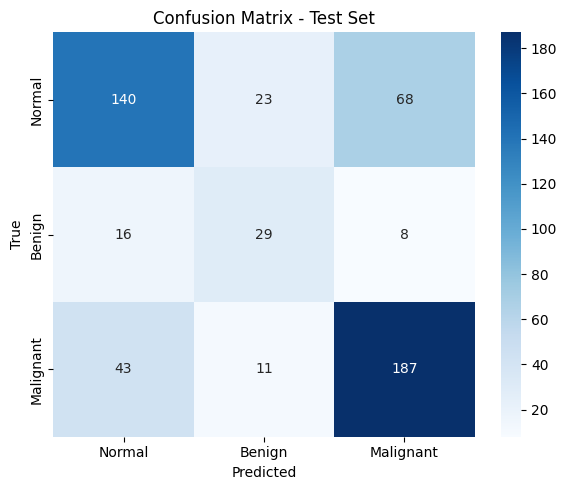

In [ ]:
# ===================== Custom Dataset =====================
class CustomImageDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform
        self.classes = sorted(self.df['label'].unique())
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.loc[idx, 'image_path']
        label = self.df.loc[idx, 'label']
        image = Image.open(img_path).convert("L") 
        if self.transform:
            image = self.transform(image)
        return image, self.class_to_idx[label]

# ===================== Transforms =====================
IMG_SIZE = 224
BATCH_SIZE = 32

val_test_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])


# ===================== Datasets & Dataloaders =====================
train_dataset = CustomImageDataset(train_df_aug, transform=val_test_transform)
val_dataset   = CustomImageDataset(val_df, transform=val_test_transform)
test_dataset  = CustomImageDataset(test_df, transform=val_test_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)


# ===================== Evaluation Function =====================
def evaluate_model(model, dataloader, device, class_names, dataset_name="Dataset"):
    model.eval()
    y_true, y_pred = [], []

    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc=f"Evaluating {dataset_name}"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    print(f"\nClassification Report for {dataset_name}:\n")
    print(classification_report(y_true, y_pred, target_names=class_names, zero_division=0))

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Confusion Matrix - {dataset_name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.show()
# ===================== Run Evaluation =====================
class_names = ['Normal', 'Benign', 'Malignant']

evaluate_model(d121_full, train_loader, device, class_names, dataset_name="Train Set")
evaluate_model(d121_full, val_loader, device, class_names, dataset_name="Validation Set")
evaluate_model(d121_full, test_loader, device, class_names, dataset_name="Test Set")

**d121_full: Classification Report + Confusion Matrix:**

Generating Scores for Train: 100%|██████████| 73/73 [14:24<00:00, 11.85s/it]


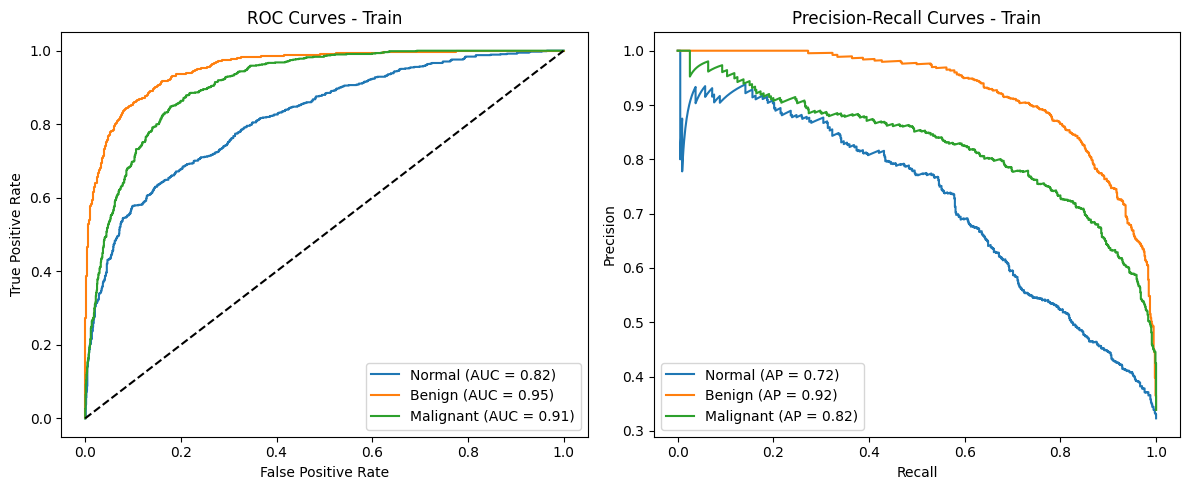

Generating Scores for Validation: 100%|██████████| 13/13 [02:29<00:00, 11.46s/it]


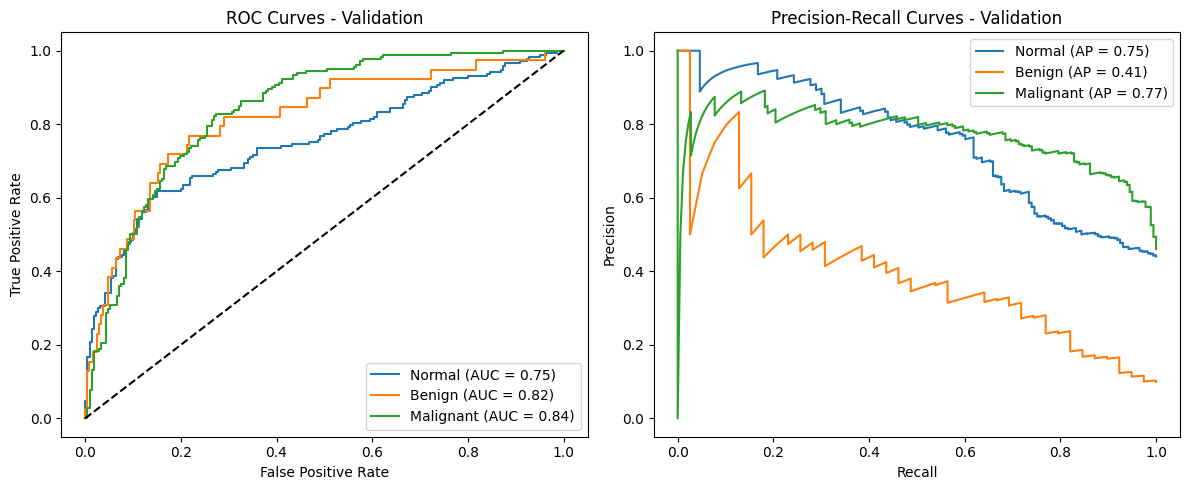

Generating Scores for Test: 100%|██████████| 17/17 [03:17<00:00, 11.64s/it]


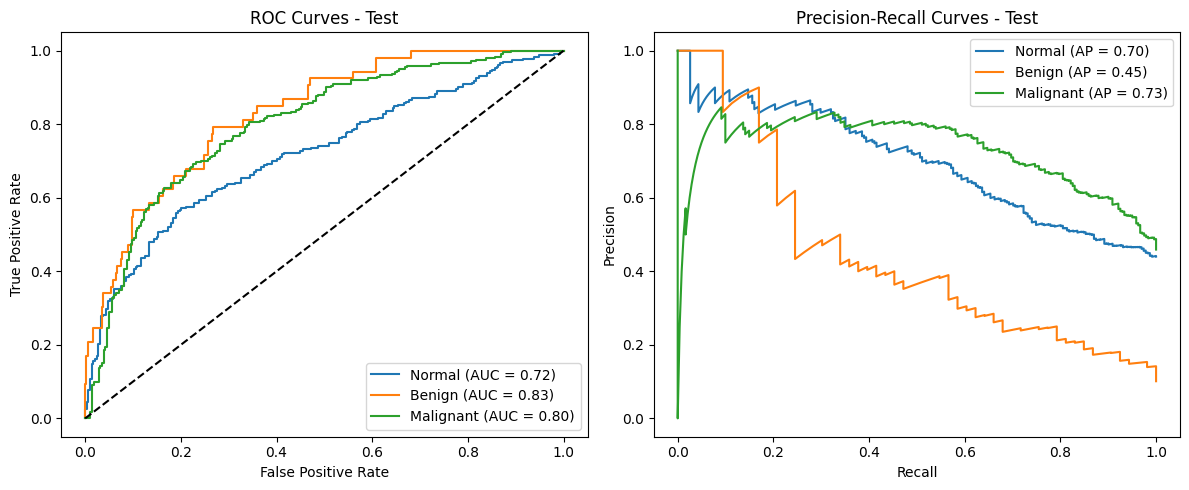

In [ ]:
plot_roc_pr_curves(d121_full, train_loader, "Train")
plot_roc_pr_curves(d121_full, val_loader, "Validation")
plot_roc_pr_curves(d121_full, test_loader, "Test")

**d121_full: Plot Training Curves (Accuracy & Loss)**

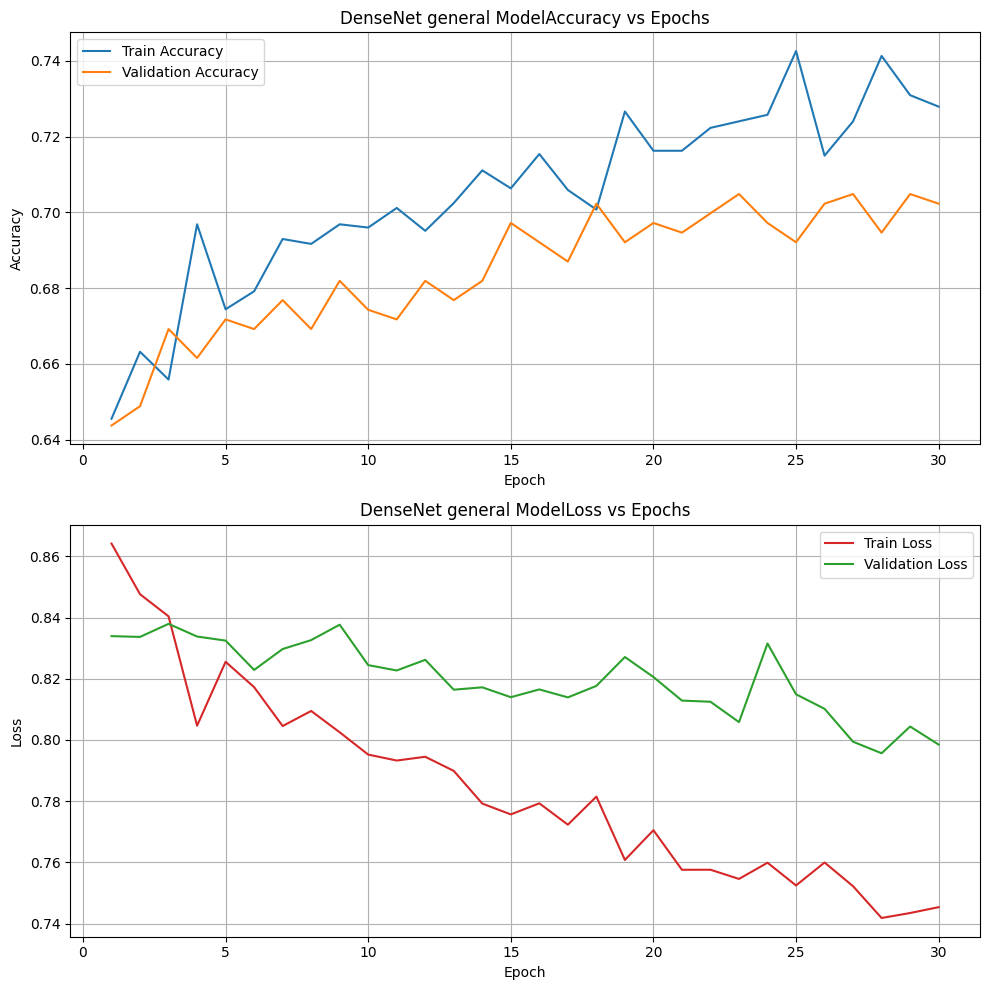

In [ ]:
# Load training log
log_path = os.path.join('/content/drive/MyDrive/CV_Project', "training_log_ft_40layers.csv")
log_df = pd.read_csv(log_path)

plot_training_curves(log_df,title_prefix = 'DenseNet general Model')

---
### **MODEL-2:**

In [ ]:
# Constants
IMG_SIZE = 224
BATCH_SIZE = 32
class_names = ['Normal', 'Benign', 'Malignant']
label_map = {'Normal': 0, 'Benign': 1, 'Malignant': 2}

**Dataset and Transforms:**

In [ ]:
def extract_first_rectangle(json_path):
    with open(json_path, 'r') as f:
        data = json.load(f)
    for shape in data['shapes']:
        if shape['shape_type'] == 'rectangle':
            (x1, y1), (x2, y2) = shape['points']
            return (int(min(x1, x2)), int(min(y1, y2)), int(max(x1, x2)), int(max(y1, y2)))
    return None

class XRayBBDataset(Dataset):
    def __init__(self, dataframe, transform=None, annotations_dir=None):
        self.df = dataframe.reset_index(drop=True)
        self.transform = transform
        self.annotations_dir = annotations_dir
        self.class_to_idx = {'Normal': 0, 'Benign': 1, 'Malignant': 2}

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.loc[idx, 'image_path']
        label = self.class_to_idx[self.df.loc[idx, 'label']]
        img = Image.open(img_path).convert("RGB")

        # Crop bounding box for Benign and Malignant
        if self.df.loc[idx, 'label'] in ['Benign', 'Malignant']:
            json_name = os.path.splitext(os.path.basename(img_path))[0] + '.json'
            json_path = os.path.join(self.annotations_dir, json_name)
            if os.path.exists(json_path):
                bbox = extract_first_rectangle(json_path)
                if bbox:
                    img = img.crop(bbox)

        img = img.convert('L')
        img = ImageOps.pad(img, (IMG_SIZE, IMG_SIZE), color=0)

        if self.transform:
            img = self.transform(img)

        return img, label

# Transforms
mean = [0.5]
std = [0.5]

transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])


**Prepare Data Loaders:**

In [ ]:
model_df = main_df[(main_df['lower limb'] == 1) | (main_df['pelvis'] == 1)]
from sklearn.model_selection import train_test_split

train_df, temp_df = train_test_split(model_df, stratify=model_df['label'], test_size=0.35, random_state=369)
val_df, test_df = train_test_split(temp_df, stratify=temp_df['label'], test_size=20/35, random_state=369)

train_dataset = XRayBBDataset(train_df, transform=transform, annotations_dir=ANNOTATIONS_DIR)
val_dataset = XRayBBDataset(val_df, transform=transform, annotations_dir=ANNOTATIONS_DIR)
test_dataset = XRayBBDataset(test_df, transform=transform, annotations_dir=ANNOTATIONS_DIR)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)


---
### DenseNet121 With Bounding Box Frozen Model:
**D121_bb_ph1: Classification Report + Confusion Matrix:**

Evaluating Train: 100%|██████████| 54/54 [09:00<00:00, 10.00s/it]


Classification Report - Train
              precision    recall  f1-score   support

      Normal       0.99      0.98      0.98       785
      Benign       0.90      0.88      0.89       749
   Malignant       0.51      0.61      0.56       170

    accuracy                           0.90      1704
   macro avg       0.80      0.82      0.81      1704
weighted avg       0.91      0.90      0.90      1704



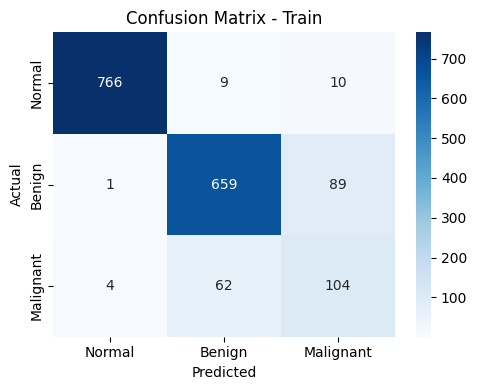

Evaluating Validation: 100%|██████████| 13/13 [02:04<00:00,  9.57s/it]


Classification Report - Validation
              precision    recall  f1-score   support

      Normal       0.97      0.97      0.97       181
      Benign       0.87      0.79      0.83       173
   Malignant       0.37      0.51      0.43        39

    accuracy                           0.85       393
   macro avg       0.74      0.76      0.74       393
weighted avg       0.87      0.85      0.85       393



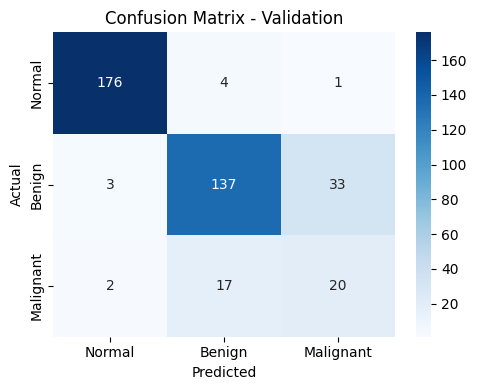

Evaluating Test: 100%|██████████| 17/17 [02:43<00:00,  9.59s/it]


Classification Report - Test
              precision    recall  f1-score   support

      Normal       1.00      0.96      0.98       241
      Benign       0.87      0.86      0.86       231
   Malignant       0.44      0.53      0.48        53

    accuracy                           0.87       525
   macro avg       0.77      0.78      0.77       525
weighted avg       0.88      0.87      0.88       525



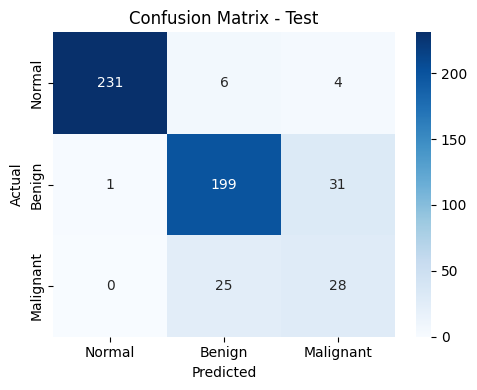

In [ ]:
# Run evaluations
evaluate_and_plot_cm(D121_bb_ph1, train_loader, class_names, "Train")
evaluate_and_plot_cm(D121_bb_ph1, val_loader, class_names, "Validation")
evaluate_and_plot_cm(D121_bb_ph1, test_loader, class_names, "Test")

**D121_bb_ph1: ROC + PR Curves:**

Generating Scores for Train: 100%|██████████| 54/54 [09:22<00:00, 10.41s/it]


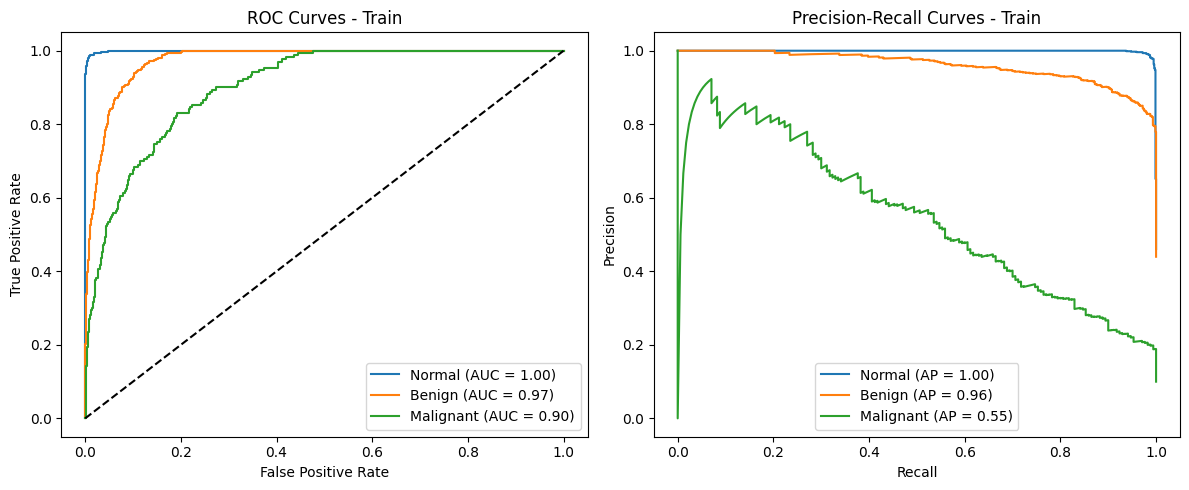

Generating Scores for Validation: 100%|██████████| 13/13 [02:04<00:00,  9.59s/it]


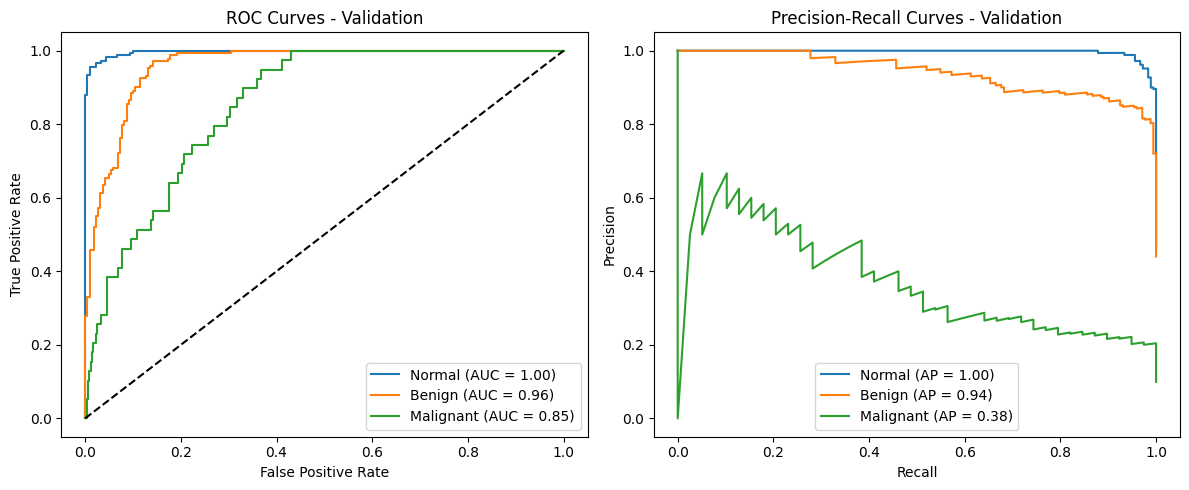

Generating Scores for Test: 100%|██████████| 17/17 [02:44<00:00,  9.70s/it]


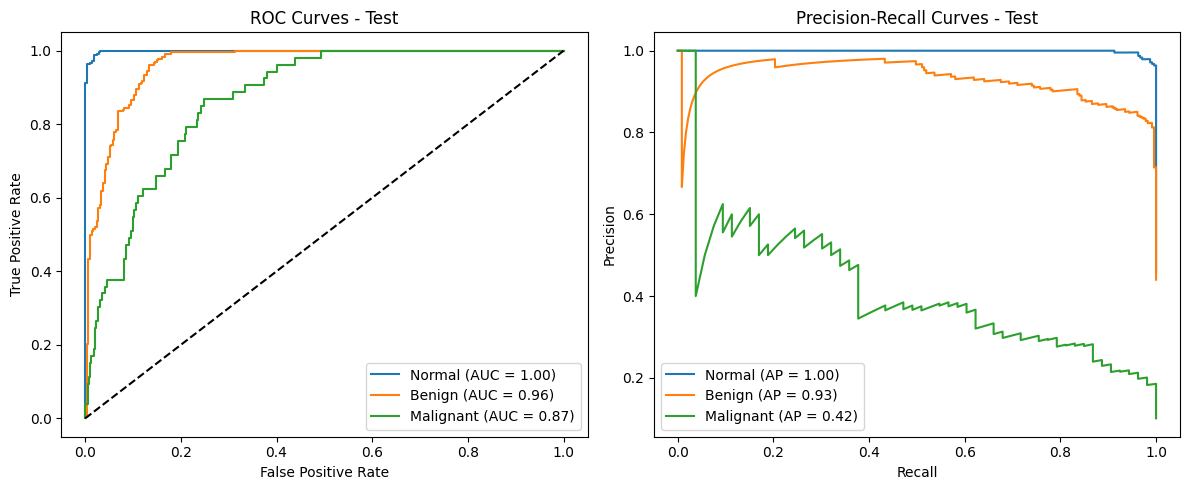

In [ ]:
plot_roc_pr_curves(D121_bb_ph1, train_loader, "Train")
plot_roc_pr_curves(D121_bb_ph1, val_loader, "Validation")
plot_roc_pr_curves(D121_bb_ph1, test_loader, "Test")

**D121_bb_ph1: Plot Training Curves (Accuracy & Loss)**

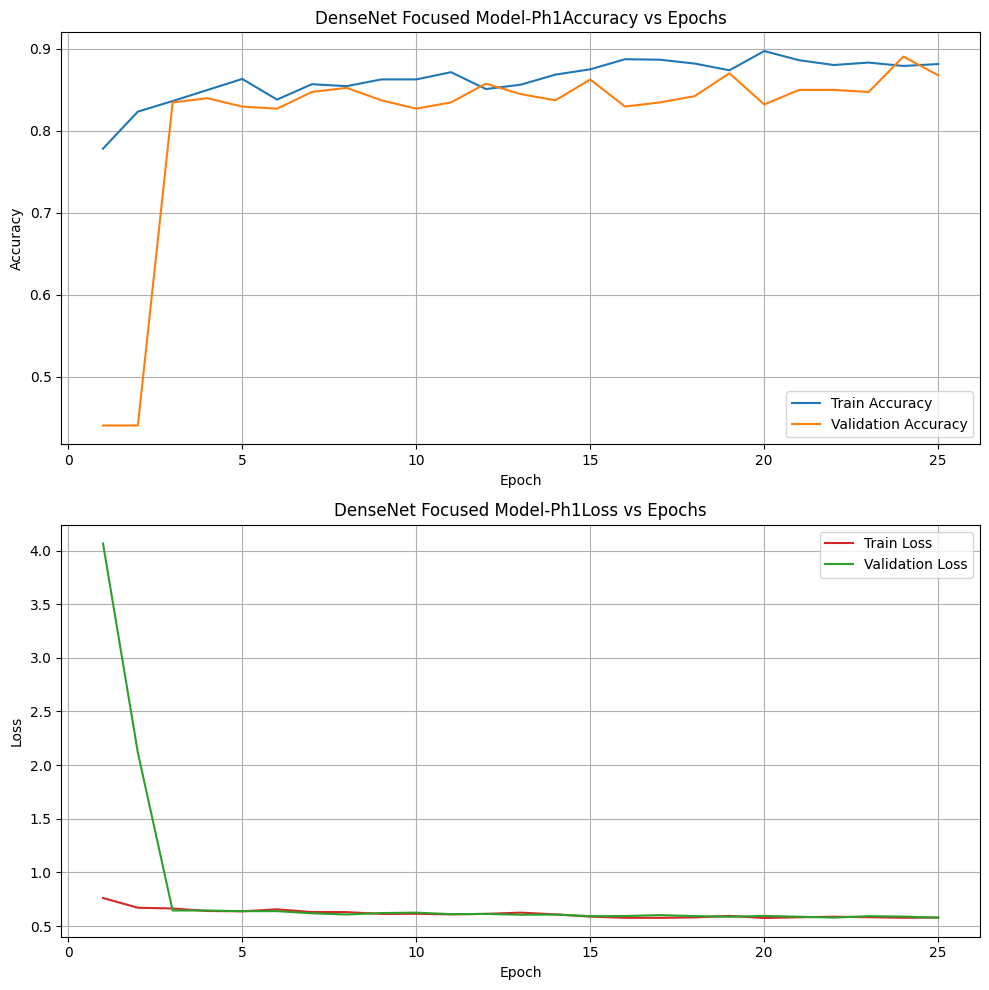

In [ ]:
# Load training log
log_path = os.path.join(HISTORY_DIR, "log_dense_bb_phase1.csv")
log_df = pd.read_csv(log_path)

plot_training_curves(log_df,title_prefix = 'DenseNet Focused Model-Ph1')

---
### DenseNet121 With Bounding Box Unfrozen & FineTuned Model:

**D121_bb_ph2: Classification Report + Confusion Matrix:**

Evaluating Train: 100%|██████████| 54/54 [09:08<00:00, 10.16s/it]


Classification Report - Train
              precision    recall  f1-score   support

      Normal       0.99      0.98      0.98       785
      Benign       0.90      0.88      0.89       749
   Malignant       0.51      0.61      0.56       170

    accuracy                           0.90      1704
   macro avg       0.80      0.82      0.81      1704
weighted avg       0.91      0.90      0.90      1704



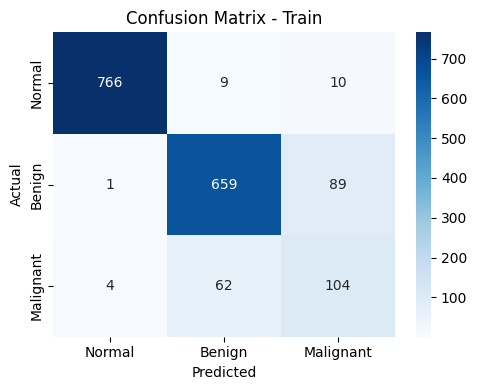

Evaluating Validation: 100%|██████████| 13/13 [02:05<00:00,  9.69s/it]


Classification Report - Validation
              precision    recall  f1-score   support

      Normal       0.97      0.97      0.97       181
      Benign       0.87      0.79      0.83       173
   Malignant       0.37      0.51      0.43        39

    accuracy                           0.85       393
   macro avg       0.74      0.76      0.74       393
weighted avg       0.87      0.85      0.85       393



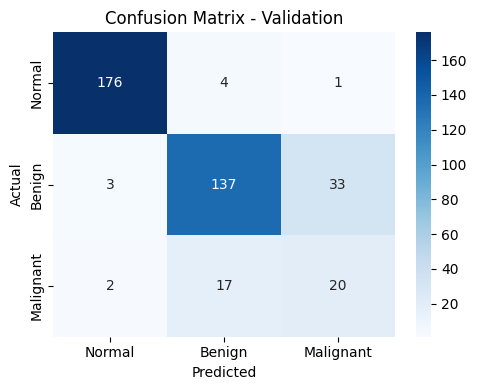

Evaluating Test: 100%|██████████| 17/17 [02:46<00:00,  9.80s/it]


Classification Report - Test
              precision    recall  f1-score   support

      Normal       1.00      0.96      0.98       241
      Benign       0.87      0.86      0.86       231
   Malignant       0.44      0.53      0.48        53

    accuracy                           0.87       525
   macro avg       0.77      0.78      0.77       525
weighted avg       0.88      0.87      0.88       525



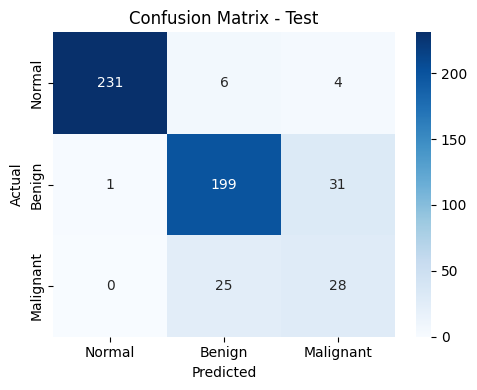

In [ ]:
# Run evaluations
evaluate_and_plot_cm(D121_bb_ph2, train_loader, class_names, "Train")
evaluate_and_plot_cm(D121_bb_ph2, val_loader, class_names, "Validation")
evaluate_and_plot_cm(D121_bb_ph2, test_loader, class_names, "Test")


### **DenseNet121 with Bounding Box Unfrozen & Fine Tuned model Binary Evaluation:**
Normal Vs Tumor:

Evaluating Train: 100%|██████████| 54/54 [09:02<00:00, 10.05s/it]


Classification Report - Train
              precision    recall  f1-score   support

      Normal       0.99      0.98      0.98       785
      Benign       0.90      0.88      0.89       749
   Malignant       0.51      0.61      0.56       170

    accuracy                           0.90      1704
   macro avg       0.80      0.82      0.81      1704
weighted avg       0.91      0.90      0.90      1704



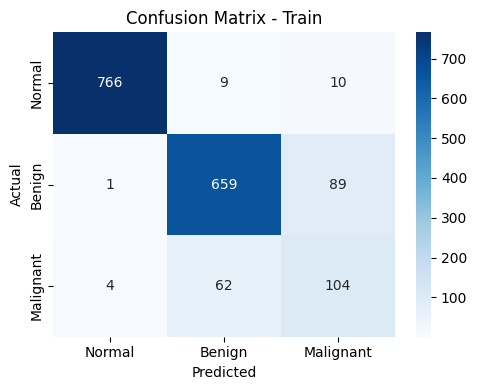

Evaluating Validation: 100%|██████████| 13/13 [02:07<00:00,  9.82s/it]


Classification Report - Validation
              precision    recall  f1-score   support

      Normal       0.97      0.97      0.97       181
      Benign       0.87      0.79      0.83       173
   Malignant       0.37      0.51      0.43        39

    accuracy                           0.85       393
   macro avg       0.74      0.76      0.74       393
weighted avg       0.87      0.85      0.85       393



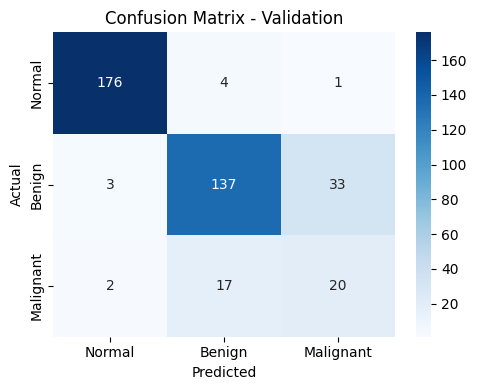

Evaluating Test: 100%|██████████| 17/17 [02:47<00:00,  9.86s/it]


Classification Report - Test
              precision    recall  f1-score   support

      Normal       1.00      0.96      0.98       241
      Benign       0.87      0.86      0.86       231
   Malignant       0.44      0.53      0.48        53

    accuracy                           0.87       525
   macro avg       0.77      0.78      0.77       525
weighted avg       0.88      0.87      0.88       525



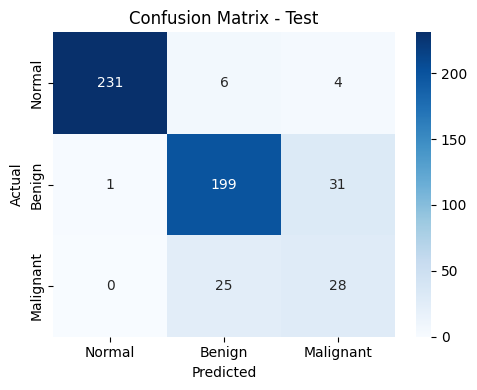

(array([0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0,
        1, 0, 0, 2, 1, 1, 1, 2, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 2, 2, 2, 0,
        1, 2, 0, 1, 2, 1, 2, 1, 0, 0, 1, 1, 2, 2, 1, 0, 1, 0, 0, 0, 1, 0,
        0, 1, 0, 0, 0, 1, 0, 2, 0, 2, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0,
        2, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1,
        1, 1, 1, 0, 0, 1, 0, 2, 1, 0, 1, 2, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0,
        0, 0, 1, 1, 2, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 2,
        0, 1, 2, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
        1, 1, 1, 1, 1, 1, 0, 2, 1, 0, 1, 2, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0,
        0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 2, 1, 1, 0, 1, 0,
        0, 0, 0, 1, 1, 0, 2, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0,
        1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0,
        0, 2, 0, 1, 0, 2, 1, 2, 0, 1, 2, 1, 1, 0, 1, 1, 1, 1, 0, 2, 0, 0,
        1, 0, 1, 1, 0, 1, 2, 1, 1, 0, 

In [ ]:
# Run evaluations
evaluate_and_plot_cm(D121_bb_ph2, train_loader, class_names, "Train")
evaluate_and_plot_cm(D121_bb_ph2, val_loader, class_names, "Validation")
evaluate_and_plot_cm(D121_bb_ph2, test_loader, class_names, "Test")

Evaluating Test: 100%|██████████| 17/17 [02:50<00:00, 10.03s/it]


Classification Report - Test
              precision    recall  f1-score   support

      Normal       1.00      0.96      0.98       241
      Benign       0.87      0.86      0.86       231
   Malignant       0.44      0.53      0.48        53

    accuracy                           0.87       525
   macro avg       0.77      0.78      0.77       525
weighted avg       0.88      0.87      0.88       525



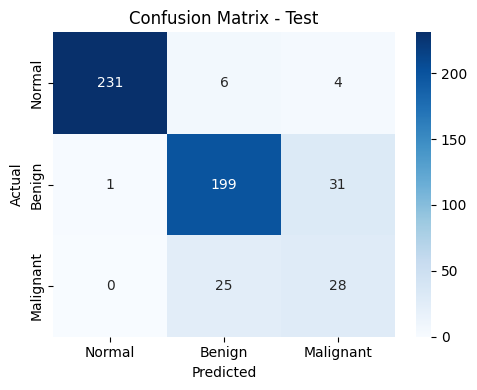

Binary Classification Report (Normal vs Tumor) - Test
              precision    recall  f1-score   support

      Normal       1.00      0.95      0.97       241
       Tumor       0.96      1.00      0.98       284

    accuracy                           0.97       525
   macro avg       0.98      0.97      0.97       525
weighted avg       0.97      0.97      0.97       525



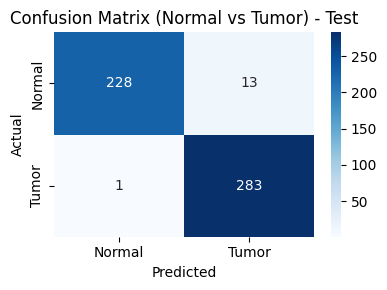

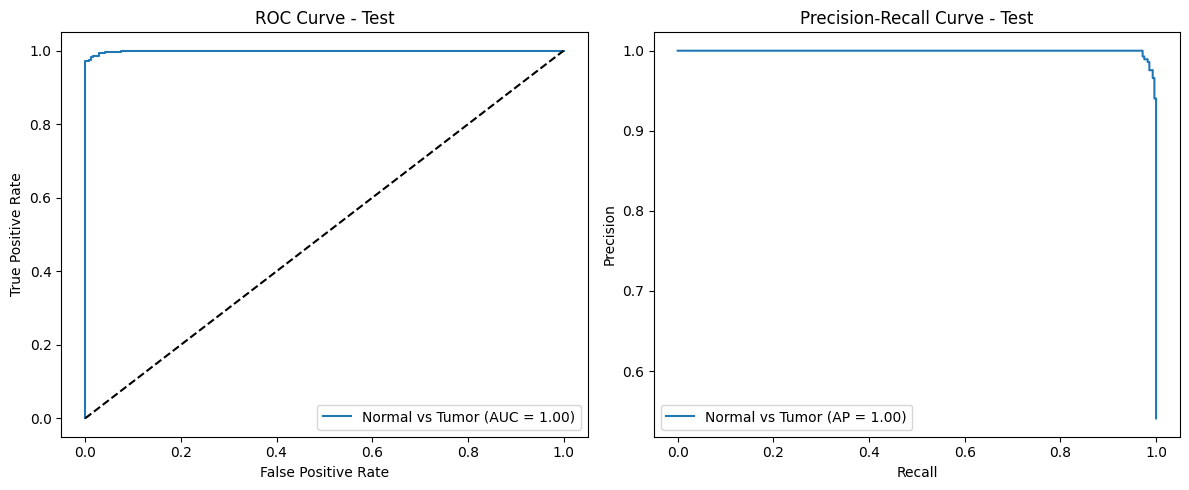

In [ ]:
y_true, y_scores = evaluate_and_plot_cm(D121_bb_ph2, test_loader, class_names, "Test")

binary_normal_vs_tumor_analysis(y_true, y_scores, dataset_name="Test")


**D121_bb_ph2: ROC + PR Curves:**

Generating Scores for Train: 100%|██████████| 54/54 [08:57<00:00,  9.95s/it]


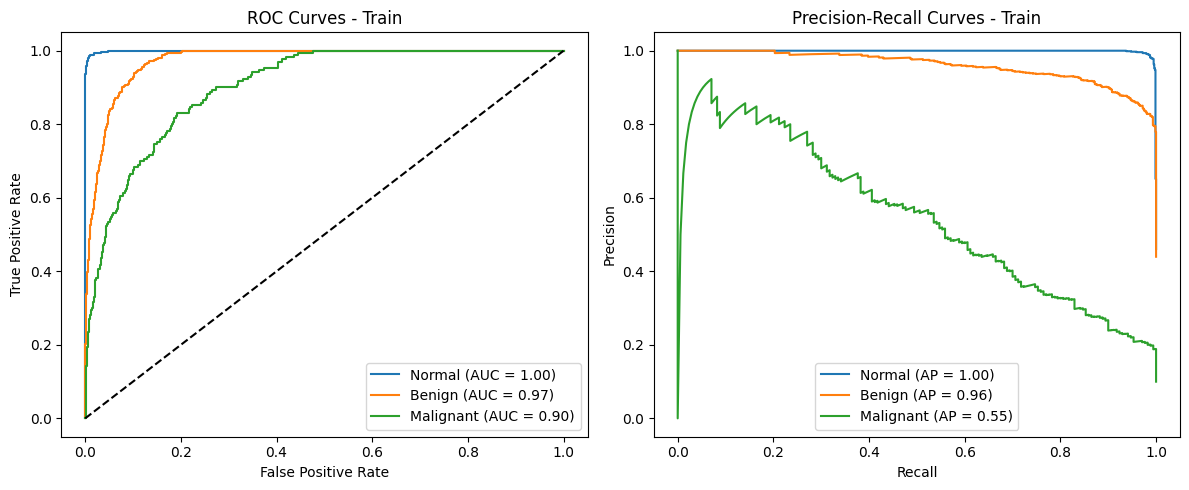

Generating Scores for Validation: 100%|██████████| 13/13 [02:05<00:00,  9.62s/it]


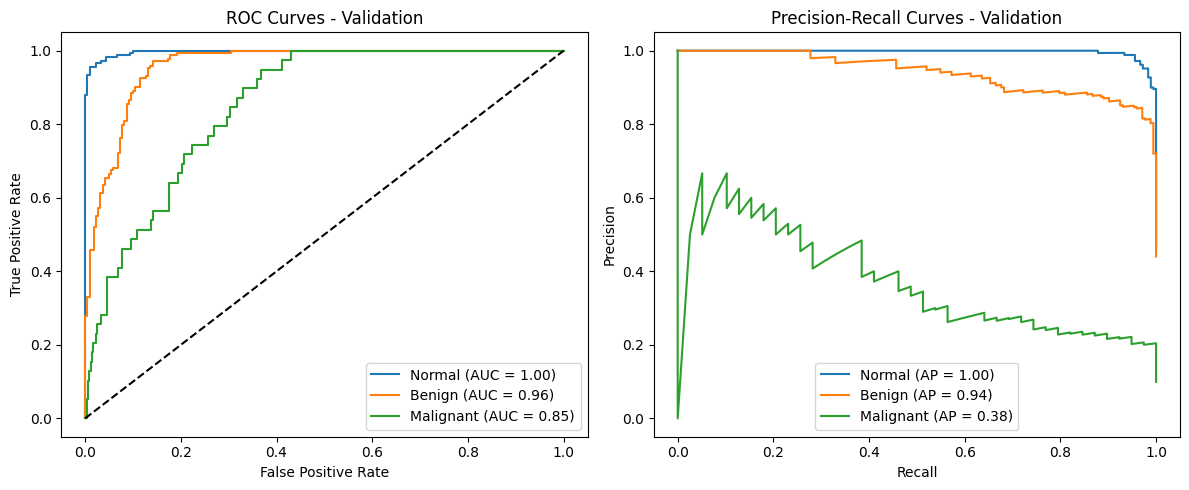

Generating Scores for Test: 100%|██████████| 17/17 [02:50<00:00, 10.00s/it]


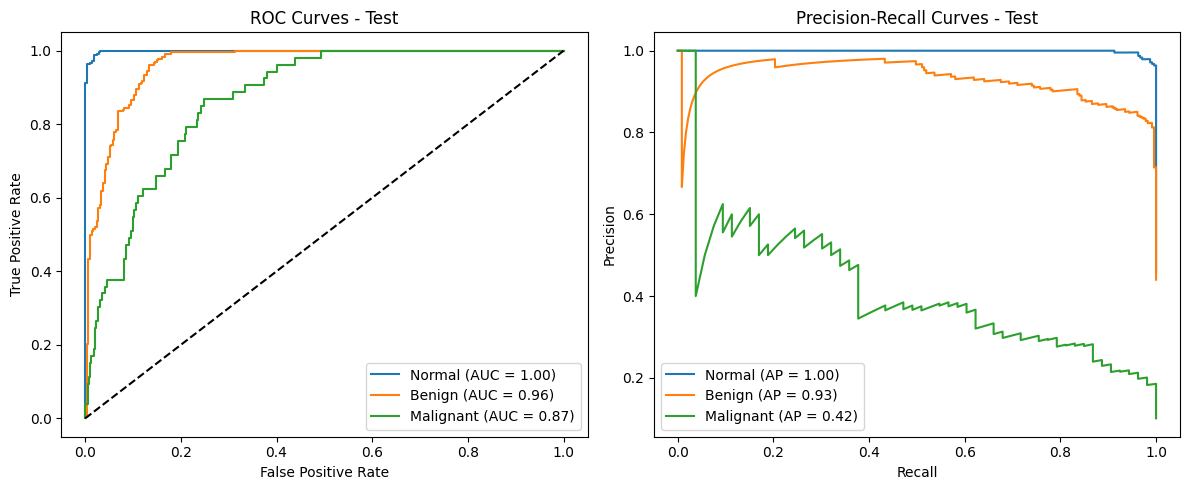

In [ ]:
plot_roc_pr_curves(D121_bb_ph2, train_loader, "Train")
plot_roc_pr_curves(D121_bb_ph2, val_loader, "Validation")
plot_roc_pr_curves(D121_bb_ph2, test_loader, "Test")

**D121_bb_ph2: Plot Training Curves (Accuracy & Loss)**

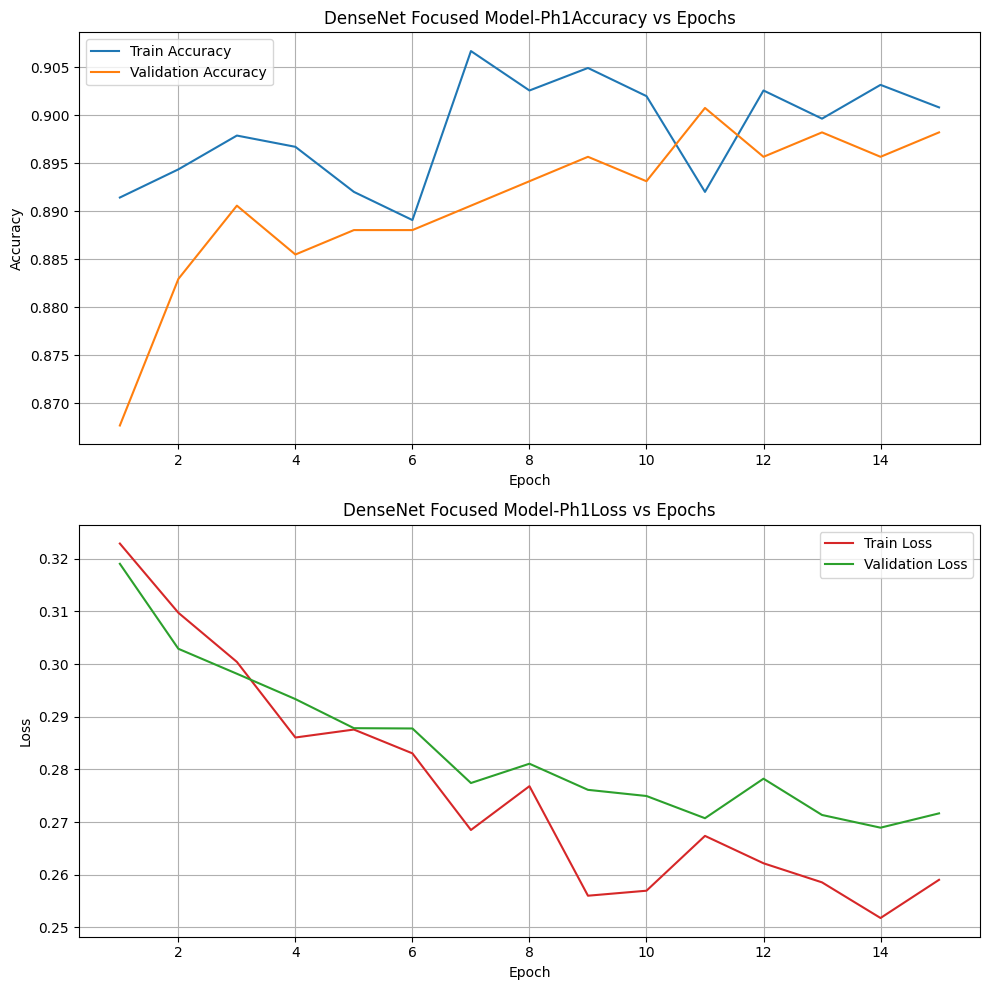

In [ ]:
log_path = os.path.join(HISTORY_DIR, "log_dense_bb_phase2.csv")
log_df = pd.read_csv(log_path)

plot_training_curves(log_df,title_prefix = 'DenseNet Focused Model-Ph1')


---
## **Ensemble Model**

In [ ]:
def evaluate_conditional_ensemble(general_model, specialist_model, dataloader, device, class_names, threshold=0.6):
    general_model.eval()
    specialist_model.eval()

    y_true, y_pred = [], []

    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc="Conditional Ensemble"):
            images, labels = images.to(device), labels.to(device)

            out_gen = general_model(images)
            out_spec = specialist_model(images)

            prob_gen = F.softmax(out_gen, dim=1)
            prob_spec = F.softmax(out_spec, dim=1)

            preds_gen = prob_gen.argmax(dim=1)
            preds_spec = prob_spec.argmax(dim=1)

            final_preds = []

            for i in range(len(images)):
                if preds_gen[i] == preds_spec[i]:
                    final_preds.append(preds_gen[i])  
                else:
                    top_spec_prob = prob_spec[i][preds_spec[i]].item()
                    if preds_spec[i] in [1, 2] and top_spec_prob >= threshold:
                        final_preds.append(preds_spec[i]) 
                    else:
                        final_preds.append(preds_gen[i])  

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(torch.tensor(final_preds).cpu().numpy())

    print("\n[Conditional Ensemble] Classification Report:\n")
    print(classification_report(y_true, y_pred, target_names=class_names, zero_division=0))

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title('[Conditional Ensemble] Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.show()


Conditional Ensemble: 100%|██████████| 17/17 [05:56<00:00, 20.98s/it]



[Conditional Ensemble] Classification Report:

              precision    recall  f1-score   support

      Normal       0.69      0.50      0.58       231
      Benign       0.38      0.55      0.45        53
   Malignant       0.68      0.79      0.73       241

    accuracy                           0.64       525
   macro avg       0.58      0.61      0.59       525
weighted avg       0.65      0.64      0.64       525



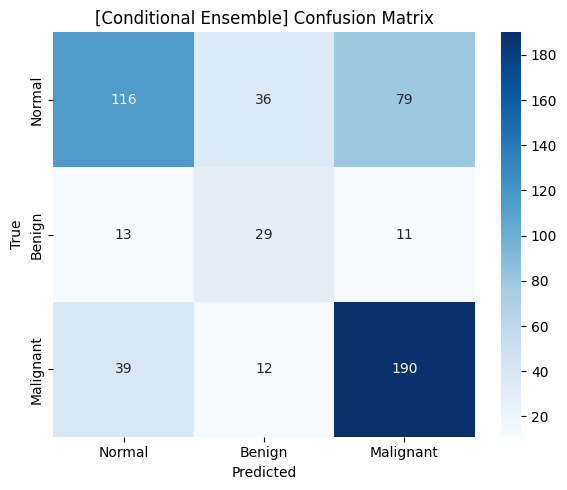

In [ ]:
evaluate_conditional_ensemble(
    d121_full,
    D121_bb_ph2,
    test_loader,
    device,
    class_names=["Normal", "Benign", "Malignant"],
    threshold=0.6
)

